In [1]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.feature import hog
from skimage import exposure
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator



from skimage import exposure
from skimage import color
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from skimage.measure import regionprops, find_contours
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


2023-07-22 03:08:51.554934: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-22 03:08:51.656798: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/diana/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-07-22 03:08:51.656813: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-22 03:08:52.222292: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dler

In [2]:
# Load the image paths and labels from the DataFrame
df = pd.read_csv('Dataset/cards.csv')

# For column names that contain space, replace the space with an underscore
df.columns = [c.replace(' ', '_') for c in df.columns]

# Add suits column
df['suit'] = df['labels'].str.split().str[-1]

# Remove rows with jokers
df = df[~df['suit'].str.contains('joker', case=False)]

# Remove unwanted columns
df = df.drop(columns = ['data_set'])
df = df.drop(columns = ['class_index'])
df = df.drop(columns = ['labels'])
df = df.drop(columns = ['card_type'])

# Add folder name to the filepath
df['filepaths'] = df['filepaths'].apply(lambda x: 'Dataset/' + x)
df.head()

,filepaths,suit
0,Dataset/train/ace of clubs/001.jpg,clubs
1,Dataset/train/ace of clubs/002.jpg,clubs
2,Dataset/train/ace of clubs/003.jpg,clubs
3,Dataset/train/ace of clubs/004.jpg,clubs
4,Dataset/train/ace of clubs/005.jpg,clubs


In [3]:
# Split dataframe into train and test sets, stratified by the 'suit' column
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['suit'], random_state=42)

# Split train set into train and validation sets, stratified by the 'suit' column
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['suit'], random_state=42)

# Check class distribution in the train, validation, and test sets
train_class_distribution = train_df['suit'].value_counts(normalize=True)
val_class_distribution = val_df['suit'].value_counts(normalize=True)
test_class_distribution = test_df['suit'].value_counts(normalize=True)

print("Train Set - Class Distribution:")
print(train_class_distribution)

print("Validation Set - Class Distribution:")
print(val_class_distribution)

print("Test Set - Class Distribution:")
print(test_class_distribution)

Train Set - Class Distribution:
spades      0.269171
hearts      0.246010
diamonds    0.243675
clubs       0.241144
Name: suit, dtype: float64
Validation Set - Class Distribution:
spades      0.269261
hearts      0.245914
diamonds    0.243580
clubs       0.241245
Name: suit, dtype: float64
Test Set - Class Distribution:
spades      0.268991
hearts      0.245953
diamonds    0.244085
clubs       0.240971
Name: suit, dtype: float64


## Augment Images

In [4]:
# Initialize data generator class

train_data_generator = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range= 45,
    zoom_range= 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range= 0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_data_generator = ImageDataGenerator(rescale = 1/255.0)

# Create data generators for train, validation, and test
batch_size = 32

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)

valid_generator = train_data_generator.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)


test_generator = test_data_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False,
)


Found 5138 validated image filenames belonging to 4 classes.
Found 1285 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


In [5]:
def preprocess_image(image):
    # Convert the image to grayscale.
    if len(image.shape) == 3 and image.shape[-1] == 3:
        image = color.rgb2gray(image)
    return image

In [6]:
# Display some sample images
def detect_suit_regions(image_path):
    image = load_img(image_path)
    image_array = img_to_array(image)

    # convert image to grayscale.
    image_array = preprocess_image(image_array)

    # Convert the image to binary using Otsu's thresholding.
    # Otsu's thresholding divides the pixels of the image into two classes: foreground and background.
    # Helps isolate region of interest for feature extraction
    binary_image = image_array > threshold_otsu(image_array)

    # Erode the binary image to enhance the suits.
    # Eroding reduces the size of the white regions of the foreground.
    eroded_image = binary_erosion(binary_image)

    # Find contours, the outlines that have the same intensity, in the eroded image.
    contours = find_contours(eroded_image, 0.8)

    # Check if any contours are detected.
    # If not, then return None
    if not contours:
        print(f"No suit regions detected for {image_path}")
        return None

    # Find the largest contour, assuming it corresponds to the suit region.
    suit_contour = max(contours, key=lambda x: x[:, 0].size)

    # Get the bounding box of the suit contour.
    minr, minc = np.min(suit_contour, axis=0).astype(int)
    maxr, maxc = np.max(suit_contour, axis=0).astype(int)

    # Check if the bounding box has valid dimensions (not too small).
    min_size = 10
    if maxr - minr < min_size or maxc - minc < min_size:
        print(f"Suit region too small for HOG features in {image_path}")
        return None

    # Crop the suit region from the original image.
    suit_image = image_array[minr:maxr, minc:maxc]

    # Calculate HOG features for the suit region.
    fd, hog_image = hog(suit_image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    # Normalize the HOG features.
    hog_features = exposure.rescale_intensity(fd, in_range=(0, 10))

    # Plot the original image and the HOG features.
    fig, ax = plt.subplots(1, 3, figsize=(8, 4))
    ax[1].imshow(suit_image, cmap='gray')
    ax[1].add_patch(patches.Rectangle((minc, minr), maxc - minc, maxr - minr, linewidth=1, edgecolor='r', facecolor='none'))
    ax[1].set_title('Suit Region')
    ax[1].axis('off')

    ax[2].imshow(hog_image, cmap='gray')
    ax[2].set_title('HOG Features')
    ax[2].axis('off')

    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    plt.show()

    return hog_features


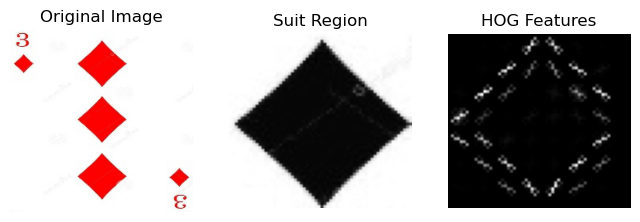

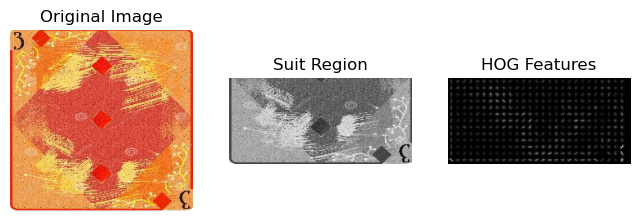

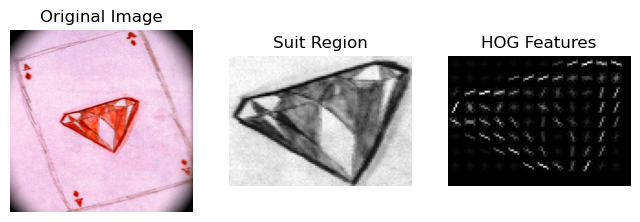

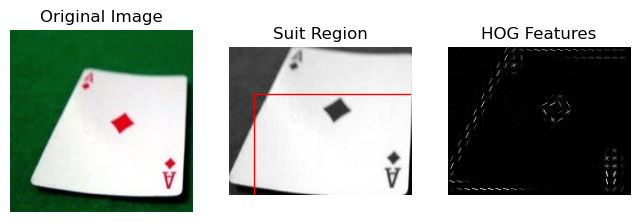

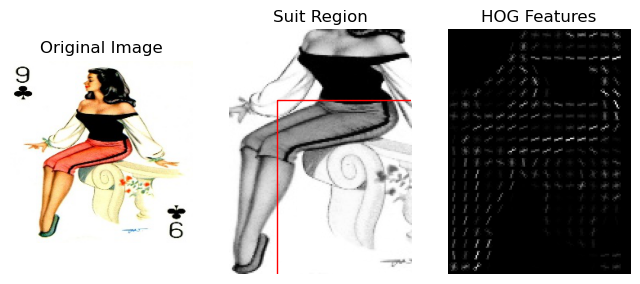

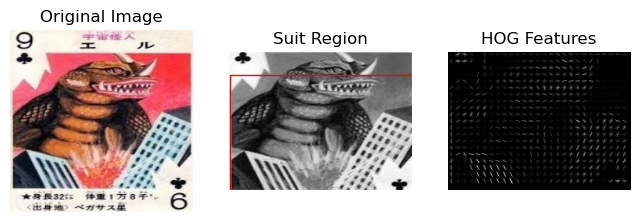

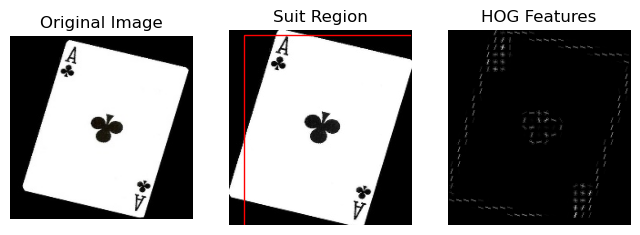

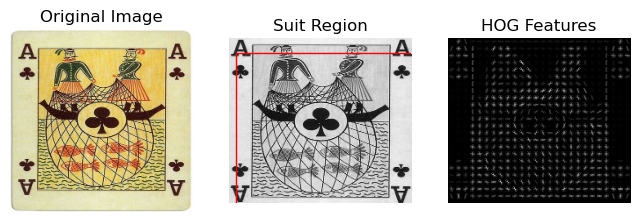

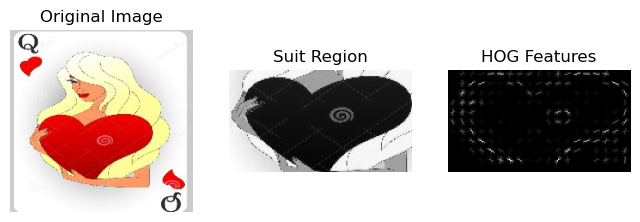

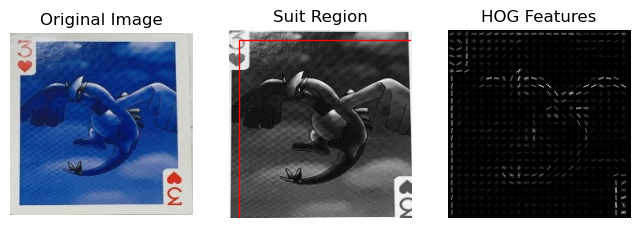

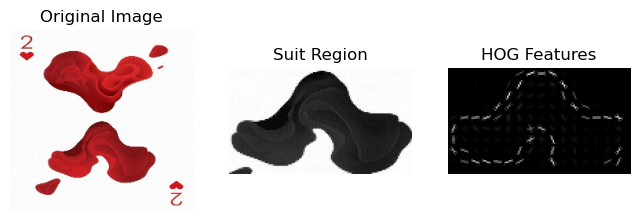

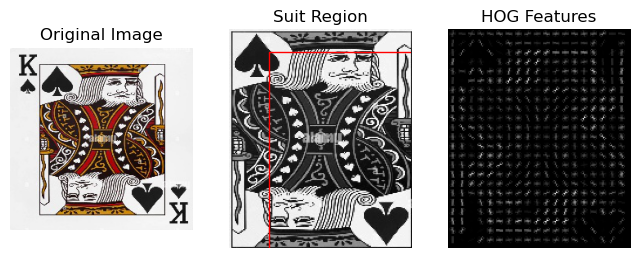

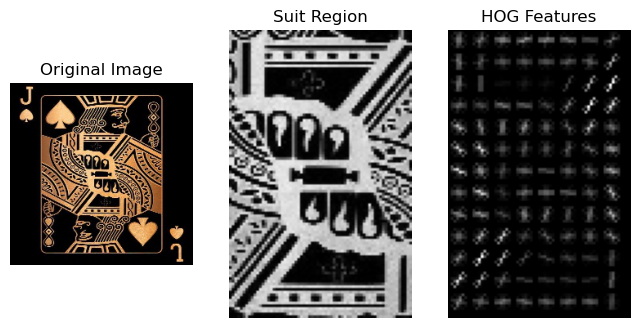

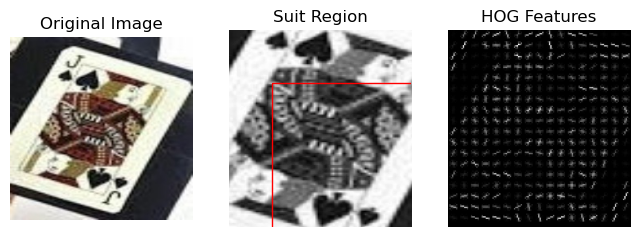

In [7]:
# Sample image paths
image_paths = [
    'Dataset/train/three of diamonds/006.jpg',
    'Dataset/train/three of diamonds/002.jpg',
    'Dataset/train/ace of diamonds/064.jpg',
    'Dataset/train/ace of diamonds/063.jpg',
    'Dataset/train/nine of clubs/024.jpg',
    'Dataset/train/nine of clubs/070.jpg',
    'Dataset/train/ace of clubs/066.jpg',
    'Dataset/train/ace of clubs/047.jpg',
    'Dataset/train/queen of hearts/005.jpg',
    'Dataset/train/three of hearts/056.jpg',
    'Dataset/train/two of hearts/033.jpg',
    'Dataset/train/king of spades/005.jpg',
    'Dataset/train/jack of spades/014.jpg',
    'Dataset/train/jack of spades/055.jpg'
]

for i in image_paths:
    detect_suit_regions(i)